# ник на kaggle: Яромир_Гусев_175565046

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()
device=torch.device('cpu')
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda")

CUDA is available!  Training on GPU ...


In [2]:
!nvidia-smi

Wed Nov 15 21:12:30 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.01                 Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   46C    P8              17W / 200W |    445MiB /  8192MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

from torchsummary import summary
from tqdm import tqdm, tqdm_notebook
from PIL import Image
import os
from pathlib import Path
from torchvision.datasets import ImageFolder
import torchvision.transforms as tfs
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pickle

ради ржаки можно поставить смешной рандомный сид xD

In [4]:
torch.manual_seed(420)
torch.cuda.manual_seed_all(420)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(420)

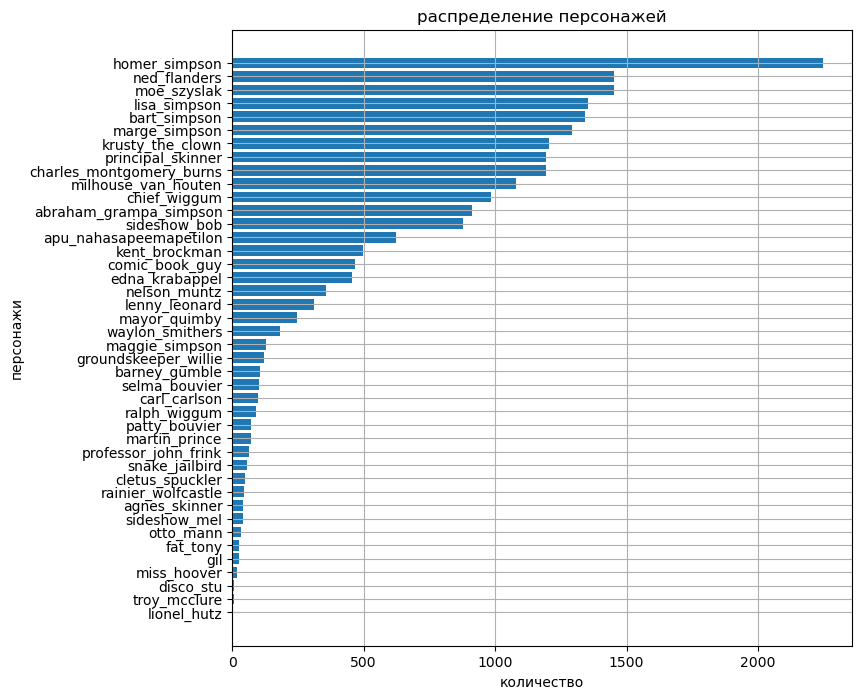

In [5]:
traind=Path(r'C:\Users\yarom\work_study\kaggle competitions\simpsons\dataset\train\simpsons_dataset')
testd=Path(r'C:\Users\yarom\work_study\kaggle competitions\simpsons\dataset\testset\testset')

train_files = sorted(list(traind.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_files]
test_files = sorted(list(testd.rglob('*.jpg')))

counts = pd.Series(train_labels).value_counts()

plt.figure(figsize=(8,8))
plt.grid()
plt.barh(counts.keys()[::-1], counts.sort_values(ascending=True))
plt.title('распределение персонажей')
plt.xlabel('количество')
plt.ylabel('персонажи')
plt.show();



получается, что распределение не особо равномерное, по хорошему надо бы сделать лютую аугментацию, иначе модель недообучится

In [6]:
modes = ['train', 'test']

class Simpsons(Dataset):
    def __init__(self, files, mode):
        self.files = files
        self.mode = mode
        self.len_ = len(self.files)
        
        if self.mode not in modes:
            print(f'{self.mode} incorrect. Use actual in {modes}.')
            raise NameError
            
        self.label_encoder = LabelEncoder()
        
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            
            with open('le.pickle', 'wb') as dumped_file:
                pickle.dump(self.label_encoder, dumped_file)
                
    def __len__(self):
        return self.len_
    
    def load_img(self, file):
        img = Image.open(file)
        img.load()
        return img
    
    def __getitem__(self, idx):
        if self.mode == 'test':
            transform = tfs.Compose([
                tfs.Resize(size=(224,224), antialias=True),
                tfs.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                tfs.ToTensor(),
                tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            augmentation = tfs.RandomChoice([
                tfs.Compose([
                    tfs.Resize(size=300, max_size=301),
                    tfs.CenterCrop(size=300),
                    tfs.RandomCrop(250)
                ]),
                tfs.RandomRotation(degrees=(-25,25)),
                tfs.RandomHorizontalFlip(p=1)
            ])
            transform = tfs.Compose([
                augmentation,
                tfs.Resize(size=(224,224), antialias=True),
                tfs.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                tfs.ToTensor(),
                tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            
        file = self.files[idx]
        x = self.load_img(file)
        x = transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[idx]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x,y

In [7]:
train_dataset = Simpsons(train_files, mode='train')
test_dataset = Simpsons(test_files, mode='test')

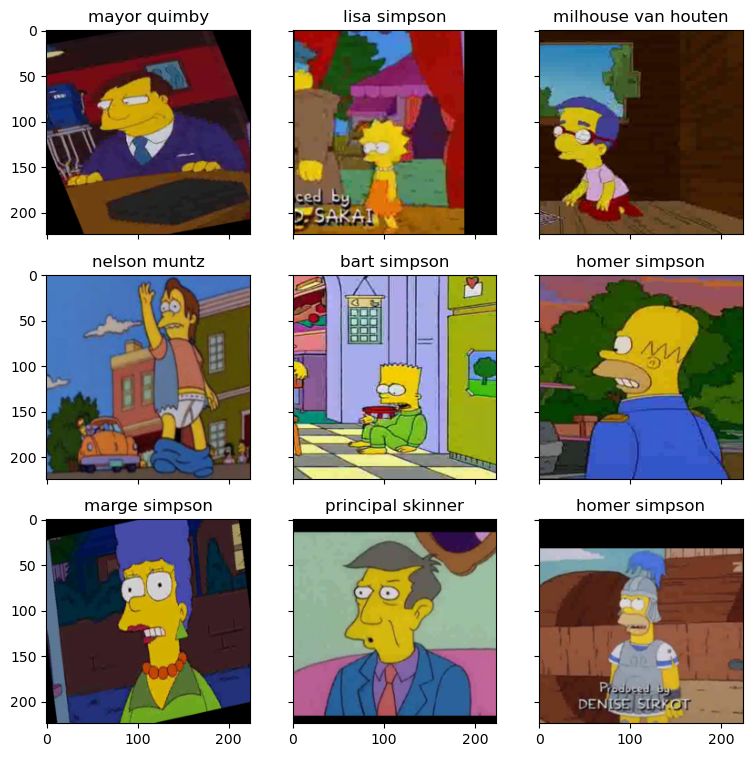

In [8]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
fig, ax = plt.subplots(figsize=(9,9), sharey=True, sharex=True,
                       nrows=3, ncols=3)

for figx in ax.ravel():
    random_character = np.array(np.random.uniform(20000), dtype='int').item()
    img, label = train_dataset[random_character]
    img = img.permute(1,2,0)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    figx.set_title(" ".join(train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    figx.imshow(img)

In [9]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [10]:
count_weights = {k: 1/v for k,v in counts.items()}
sample_weights = len(train_files) * [0]

for i, (data, label) in enumerate(tqdm(train_dataset)):
    label_weight = count_weights[train_dataset.label_encoder.inverse_transform([label])[0]]
    sample_weights[i] = label_weight

100%|███████████████████████████████████████████████████████████████████████████| 20933/20933 [01:43<00:00, 201.60it/s]


In [11]:
N = counts.max() * len(count_weights)

In [12]:
from torch.utils.data import WeightedRandomSampler

train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_dataloader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler)

In [13]:
def fit_epoch(model, train_dataloader, criterion, optimizer, scheduler):
    running_loss = 0
    running_corrects = 0
    running_data = 0
    
    for inputs, label in tqdm_notebook(train_dataloader):
        inputs = inputs.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * label.size(0)
        preds = outputs.argmax(-1)
        running_corrects += (preds == label).sum()
        running_data += label.size(0)
    
    
    scheduler.step()
    train_acc = running_corrects / running_data
    train_loss = running_loss / running_data
    
    return train_loss, train_acc

In [14]:
def train(model,epochs,batch_size,train_dataloader):
    
    history = []
    
    log_template = 'Epoch - {ep: 03d}, train loss: {tr_loss: 0.4f}, train acc: {tr_acc: 0.4f}'
    
    with tqdm(desc='Epoch', total=epochs) as pbar:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_dataloader, criterion, optimizer, scheduler)
            history.append((train_loss, train_acc))
            pbar.update(1)
            tqdm.write(log_template.format(ep=epoch+1, tr_loss = train_loss, tr_acc = train_acc))
            
    return history

In [15]:
class SimpleCNN(nn.Module):
    
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2400, out_features=4800),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=4800),
            nn.ReLU(),
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=42)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [16]:
classes = len(np.unique(train_dataset.labels))

model = SimpleCNN(classes)
model = model.to(device)

In [17]:
epochs=15
batch_size=128
train

history = train(model,epochs,batch_size,train_dataloader)

Epoch:   0%|                                                                                    | 0/15 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:   7%|████▊                                                                    | 1/15 [08:14<1:55:25, 494.71s/it]

Epoch -  01, train loss:  1.5664, train acc:  0.5673


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  13%|█████████▋                                                               | 2/15 [18:17<2:00:57, 558.29s/it]

Epoch -  02, train loss:  0.3752, train acc:  0.8894


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  20%|██████████████▌                                                          | 3/15 [27:23<1:50:32, 552.69s/it]

Epoch -  03, train loss:  0.2124, train acc:  0.9370


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  27%|███████████████████▍                                                     | 4/15 [47:26<2:28:24, 809.47s/it]

Epoch -  04, train loss:  0.1409, train acc:  0.9581


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  33%|████████████████████████▎                                                | 5/15 [55:47<1:56:20, 698.07s/it]

Epoch -  05, train loss:  0.1097, train acc:  0.9671


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  40%|████████████████████████████▍                                          | 6/15 [1:04:10<1:34:45, 631.76s/it]

Epoch -  06, train loss:  0.0506, train acc:  0.9853


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  47%|█████████████████████████████████▏                                     | 7/15 [1:12:26<1:18:20, 587.57s/it]

Epoch -  07, train loss:  0.0342, train acc:  0.9901


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  53%|█████████████████████████████████████▊                                 | 8/15 [1:20:40<1:05:03, 557.68s/it]

Epoch -  08, train loss:  0.0277, train acc:  0.9919


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  60%|███████████████████████████████████████████▊                             | 9/15 [1:29:09<54:13, 542.32s/it]

Epoch -  09, train loss:  0.0228, train acc:  0.9934


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  67%|████████████████████████████████████████████████                        | 10/15 [1:38:05<45:02, 540.51s/it]

Epoch -  10, train loss:  0.0199, train acc:  0.9943


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  73%|████████████████████████████████████████████████████▊                   | 11/15 [1:47:13<36:10, 542.67s/it]

Epoch -  11, train loss:  0.0185, train acc:  0.9951


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  80%|█████████████████████████████████████████████████████████▌              | 12/15 [1:55:25<26:22, 527.52s/it]

Epoch -  12, train loss:  0.0179, train acc:  0.9951


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  87%|██████████████████████████████████████████████████████████████▍         | 13/15 [2:03:31<17:09, 514.83s/it]

Epoch -  13, train loss:  0.0160, train acc:  0.9956


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  93%|███████████████████████████████████████████████████████████████████▏    | 14/15 [2:11:38<08:26, 506.32s/it]

Epoch -  14, train loss:  0.0167, train acc:  0.9950


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [2:19:43<00:00, 558.93s/it]

Epoch -  15, train loss:  0.0176, train acc:  0.9952


In [19]:
loss, acc = zip(*history)

In [20]:
loss, acc

((1.566360653576513,
  0.37520782318927753,
  0.21240684054044753,
  0.14090948405807135,
  0.10966196558036023,
  0.05057574706267791,
  0.03421701996651627,
  0.027688927314403085,
  0.022751006507465796,
  0.019948855216120432,
  0.01847400376496197,
  0.017865442081119152,
  0.015984513093486964,
  0.01670207609008044,
  0.01764044391647438),
 (tensor(0.5673, device='cuda:0'),
  tensor(0.8894, device='cuda:0'),
  tensor(0.9370, device='cuda:0'),
  tensor(0.9581, device='cuda:0'),
  tensor(0.9671, device='cuda:0'),
  tensor(0.9853, device='cuda:0'),
  tensor(0.9901, device='cuda:0'),
  tensor(0.9919, device='cuda:0'),
  tensor(0.9934, device='cuda:0'),
  tensor(0.9943, device='cuda:0'),
  tensor(0.9951, device='cuda:0'),
  tensor(0.9951, device='cuda:0'),
  tensor(0.9956, device='cuda:0'),
  tensor(0.9950, device='cuda:0'),
  tensor(0.9952, device='cuda:0')))

In [27]:
def predict(model, test_dataloader):
    
    logits = []
    
    with torch.no_grad():
        for data in tqdm(test_dataloader):
            data = data.to(device)
            model.eval()
            outputs = model(data)
            logits.append(outputs)
            
    return logits

In [28]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128)

In [29]:
predictions = predict(model, test_dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.21it/s]


In [30]:
preds = nn.functional.softmax(torch.cat(predictions), dim=-1).argmax(-1).cpu().numpy()

In [31]:
predictions = train_dataset.label_encoder.inverse_transform(preds)
id_lab = [path.name for path in test_files]

In [32]:
pd.DataFrame({'Id': id_lab, 'Expected': predictions}).to_csv('preds.csv', index=False)